names = ['237', '246', '255', '267', '278', '288', '292', '296', '459', '463', '464', '471', '473', '475', '481', '4931', '4935', '4937', '4938', '4939', '4942', '4944', '4946', '4953', '4957', '4958', '4963', '4966', '4967', '4970', '4975', '4976', '504', '523', '6435', '6436', '6437', '6443', '6444', '6449', '6452', '6453', '6457', '6459', '6461', '6465', '6467', '6469', '6473', '6545', '6549']
51 darab annotalt szeletunk van.


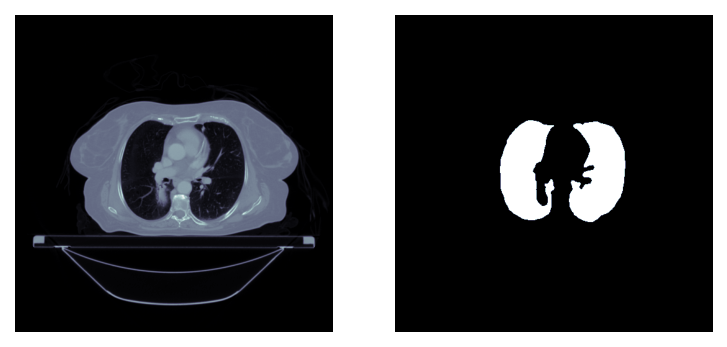

['7.35', '7.55', '7.3', '7.31', '7.26', '7.51', '7.35', '7.5', '5.82', '5.73', '6.06', '5.71', '5.96', '5.7', '7.7', '8.41', '8.03', '10.4', '9.88', '9.11', '9.01', '10.6', '7.84', '5.55', '6.87', '7.62', '9.27', '8.39', '9.16', '6.24', '10.2', '6.56', '7.94', '7.92', '10.1', '11.3', '9.83', '12.2', '12.1', '12.4', '9.51', '9.59', '10.7', '10.6', '10.4', '10.7', '11.7', '10.8', '9.99', '8.6', '9.57']


In [2]:
%run ./test_mask.ipynb

In [3]:
#%matplotlib inline
import pydicom
import numpy as np
from os.path import dirname, join
import matplotlib.pyplot as plt

import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

dcm = pydicom.dcmread("../data/pelda2.dcm")

In [4]:
def plot_two_cols(fig1, fig2, cmap=plt.cm.bone):
    plt.rcParams["figure.figsize"] = (10,10)
    fig, axs = plt.subplots(nrows=1, ncols=2, dpi=150)
    [axi.set_axis_off() for axi in axs]
    axs[0].imshow(fig1, cmap=cmap)
    axs[1].imshow(fig2, cmap=cmap)

In [5]:
# i need these from the dicomheader to calculate HU as HU = grayvalue * slope + intercept
intercept = int(dcm.RescaleIntercept)
slope = int(dcm.RescaleSlope)
pixel_spacing = float(dcm.PixelSpacing[0])
mypixels = dcm.pixel_array * slope + intercept

#mypixels=images[7]


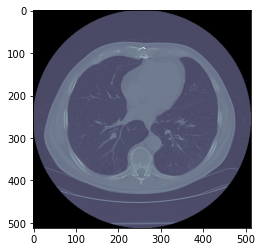

In [6]:
plt.imshow(mypixels, cmap=plt.cm.bone) 

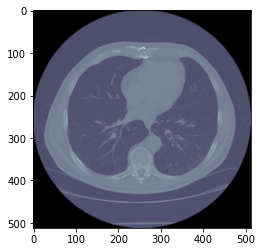

In [7]:
# gaussian smoothing 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
# TODO: how much sigma to use
from scipy.ndimage import gaussian_filter
gaussed = gaussian_filter(mypixels, sigma=pixel_spacing)
plt.imshow(gaussed,  cmap=plt.cm.bone )

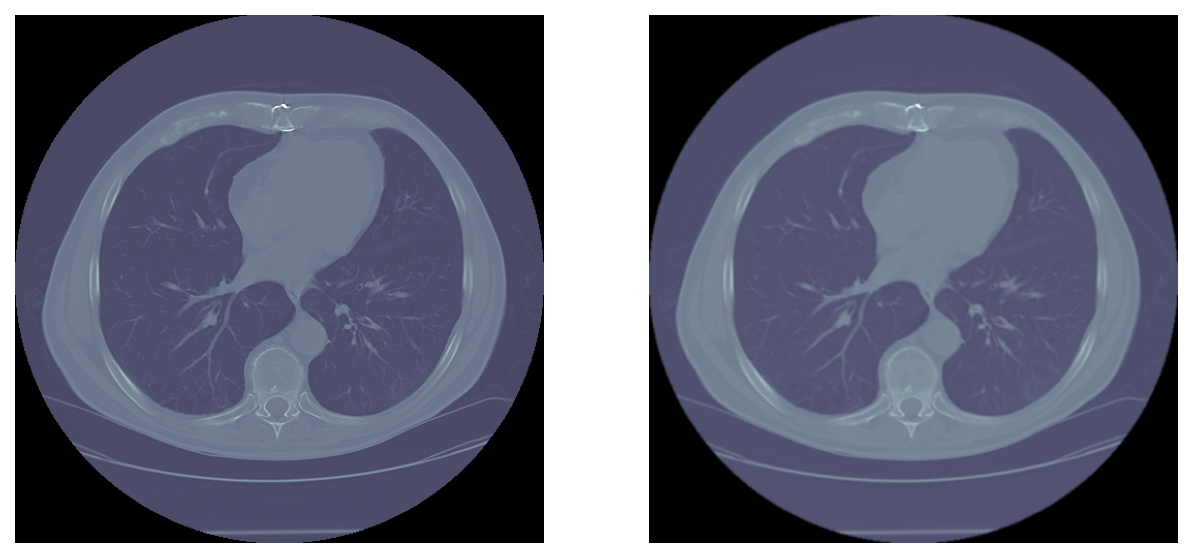

In [8]:
plot_two_cols(mypixels, gaussed)

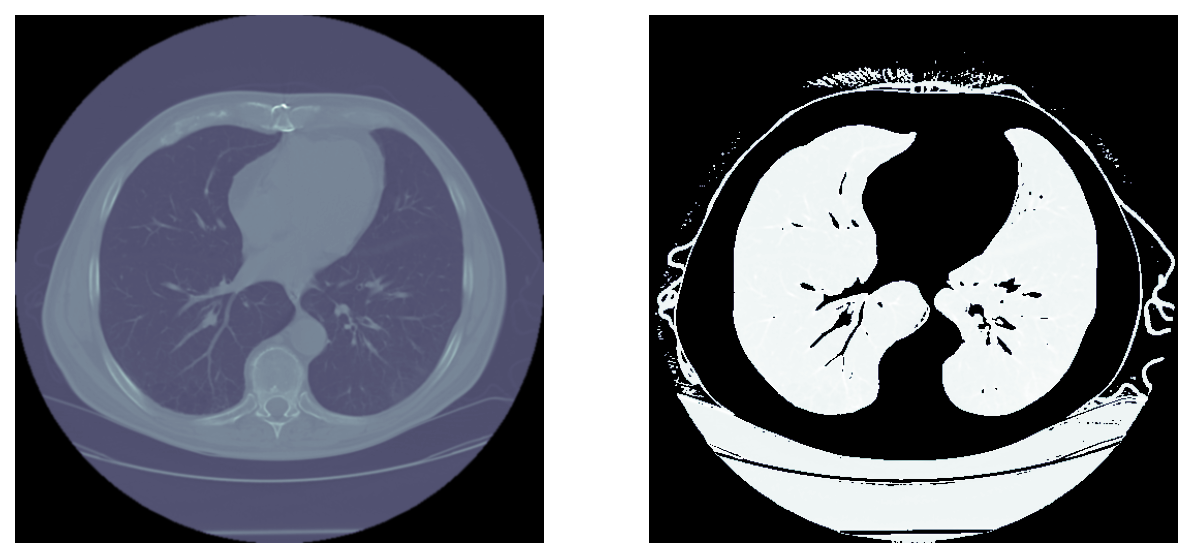

In [9]:
plt.rcParams["figure.figsize"] = (10,10)
# gray level tresholding
# TODO: experiment with other than -500
tresholded = gaussed.copy()

mask = (tresholded > -500) | (tresholded < -980)
tresholded[mask] = -10000
_ = plot_two_cols(gaussed, tresholded)

In [10]:
hstp = dcm.pixel_array * slope + intercept
#plt.hist(hstp)
plt.show()

In [11]:
hst = (hstp < -1500) & (hstp != -1024) & (hstp != -1000) 
#plt.imshow(hstp[hst])


#plt.hist(hst, bins=1000)
#plt.show()

In [12]:
hst

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

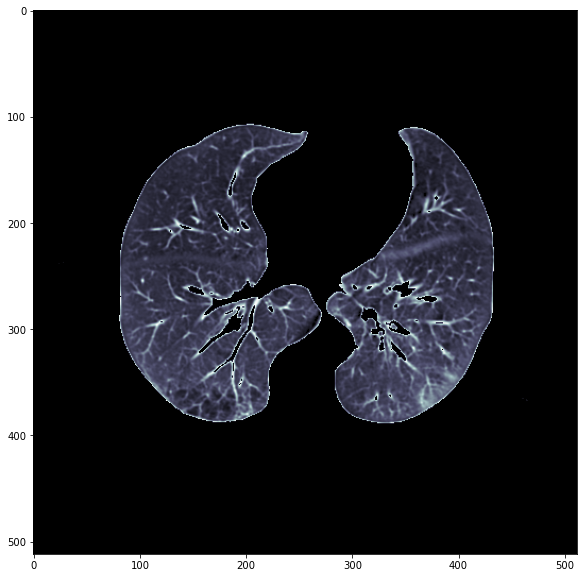

In [13]:

# floodfill non-lung region
# ASK: should i implement this manually?
from skimage.morphology import flood_fill
filled = tresholded.copy()
xmax, ymax = filled.shape
i = 0


flood_fill(filled, (i, 0), -3000, tolerance=2500,connectivity=1, inplace=True) # int(ymax*0.15)
flood_fill(filled, (i, ymax-1), -3000, tolerance=2500,connectivity=1, inplace=True) # int(ymax*0.85)

flood_fill(filled, (xmax-1, ymax-1), -3000, tolerance=2500,connectivity=1, inplace=True) # int(xmax*0.85)
flood_fill(filled, (xmax-1, i), -3000, tolerance=2500,connectivity=1, inplace=True) # int(xmax*0.85)


    
filled[filled == -10000] = -1024
filled[filled == -3000] = -1024
#%matplotlib nbagg
plt.imshow(filled,  cmap=plt.cm.bone )

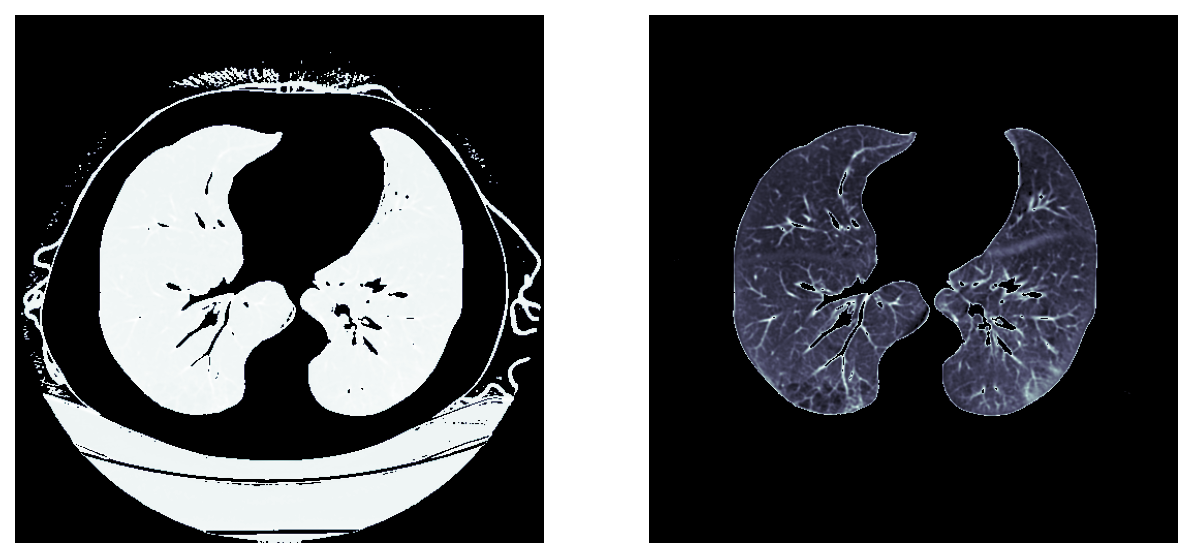

In [14]:
plot_two_cols(tresholded, filled)

In [15]:
filled

array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ...,
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

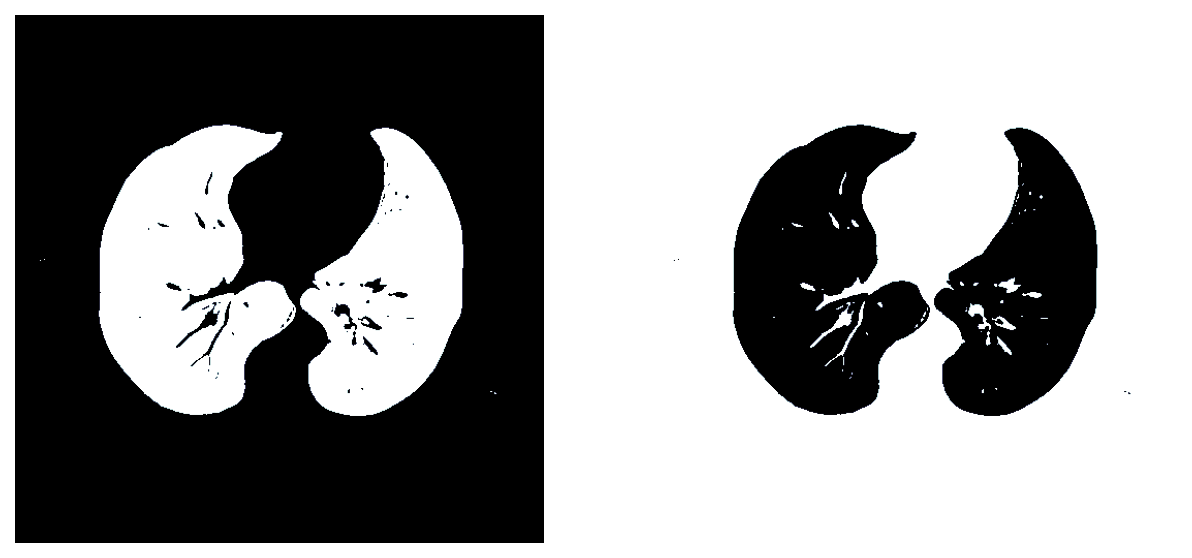

In [16]:
lung_mask = (filled != -1024)
non_lung_mask = (filled == -1024)

plot_two_cols(lung_mask, non_lung_mask)

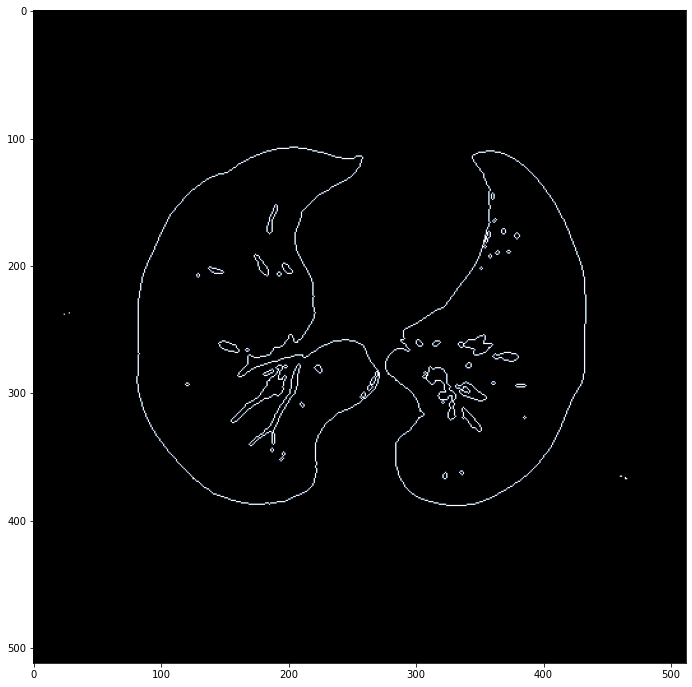

In [17]:
# Border tracing algo
import skimage.segmentation as seg

boundaries = seg.find_boundaries(lung_mask, mode="inner")
plt.rcParams["figure.figsize"] = (12,12)
plt.imshow(boundaries, cmap=plt.cm.bone)

In [18]:
def get_left_start_points(mymask):
    for i in range(mymask.shape[0]):
        if mymask[i][i]:
            return (i,i)

def get_right_start_points(mymask):
    limit = mymask.shape[0]
    for i in range(limit):
        if mymask[i,limit-1-i]:
            return (limit-1-i,i)

In [19]:
# p1 = get_border_from_startpoint(start_points[0], boundaries)
# p2 = get_border_from_startpoint(start_points[1], boundaries)
# plot_two_cols(p1, p2)

In [20]:
marching_step_lenght = 5


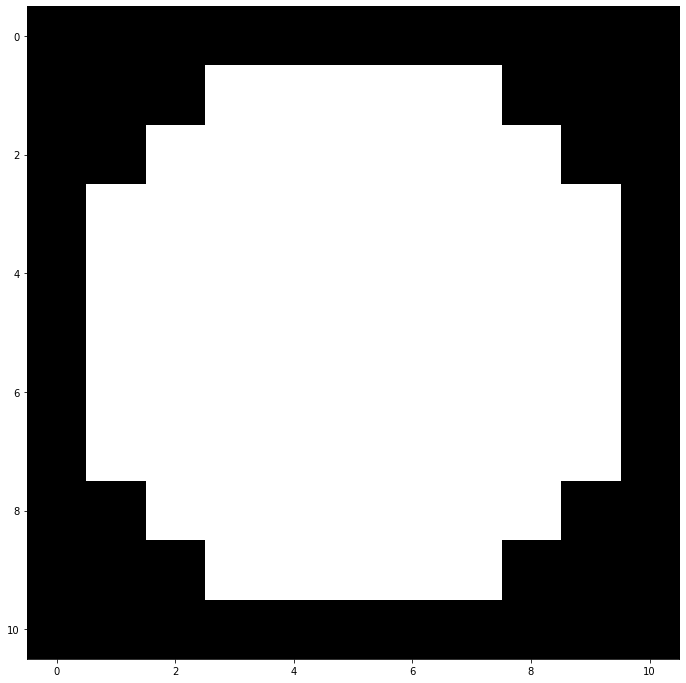

In [21]:
from skimage.draw import circle_perimeter, circle
circ = np.zeros((11, 11), dtype=np.bool)
rr, cc = circle(5, 5, 5)
circ[rr, cc] = True
circ
plt.imshow(circ, cmap=plt.cm.bone)


Begin
    {Initialization: find a pixel in P, initialize B, define M(p) to be the Moore neighborhood of the current pixel p}
    1. Set B to be empty.
    2. From bottom to top and left to right scan the cells of T until a pixel s of P is found (until the current pixel p=s is a black pixel of P), insert s in B. Let b denote the current boundary point, i.e., b=s.
    3. Backtrack (move the current pixel to the pixel from which s was entered) and advance the current pixel p being examined to the next clockwise pixel in M(b).
    while p is not equal to s do
        if p is black, insert p in B, set b=p and backtrack (move the current pixel to the pixel from
        which p=b was entered);
        else advance the current pixel p to the next clockwise pixel in M(b). end while
End

In [22]:
def neigh(s,l,T):
    directions = [(-1,0),(-1,-1),(0,-1),(1,-1),(1,0),(1,1),(0,1),(-1,1)]
    dire = tuple(np.subtract(l,s))
    ind = directions.index(dire)
    directions = directions[ind:] + directions[:ind]
    for i, dire in enumerate(directions):
        new = tuple(np.add(s,dire))
        #print('dire=',dire,'new=',new,'T=',T[new[1],new[0]])
        if T[new[1],new[0]] == True:
            last = tuple(np.add(s,directions[i-1]))
            return (new, last)


# def find_pixel(grid):
#     ind = np.nonzero(grid)
#     x = ind[0][0]
#     y = ind[1][0]
#     if x == 0 and y == 0:
#         raise ValueError('Cant backtrack. First pixel is in the topleft corner.')
#     if x == 0 and y > 0:
#         last = (grid.shape[0]-1, y-1)
#         print("baj van")
#         return ((x,y),last)
#     last = (x - 1, y)
#     print('returned in find_pixel:', ((x,y),last))
#     return ((x,y),last)

def moree(T,start,l):
    B = [start]
    b = start
    b,l = neigh(b, l, T)
    B.append(b)
    while b != start:
        b,l = neigh(b, l, T)
        if b in B:
            print('possible trouble')
            break
        B.append(b)
    return B
        

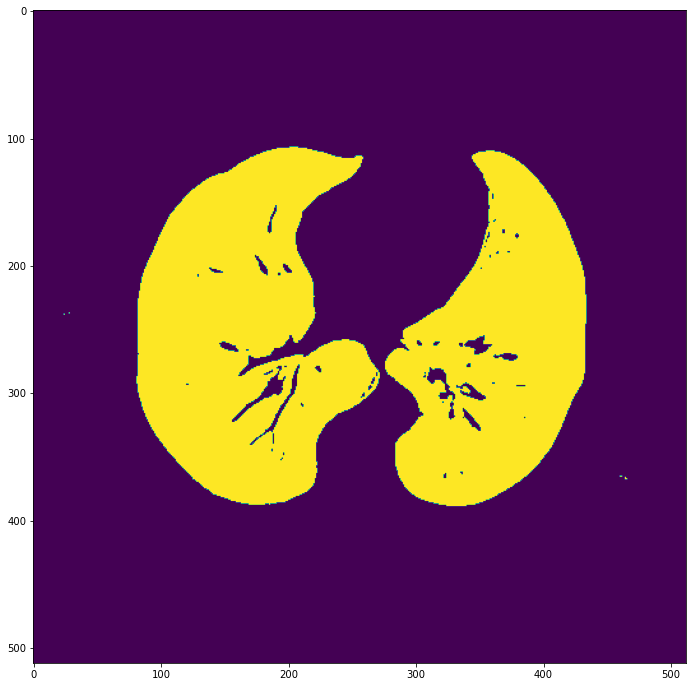

In [23]:
#%matplotlib widget
plt.imshow(lung_mask)#[90:110,190:220]

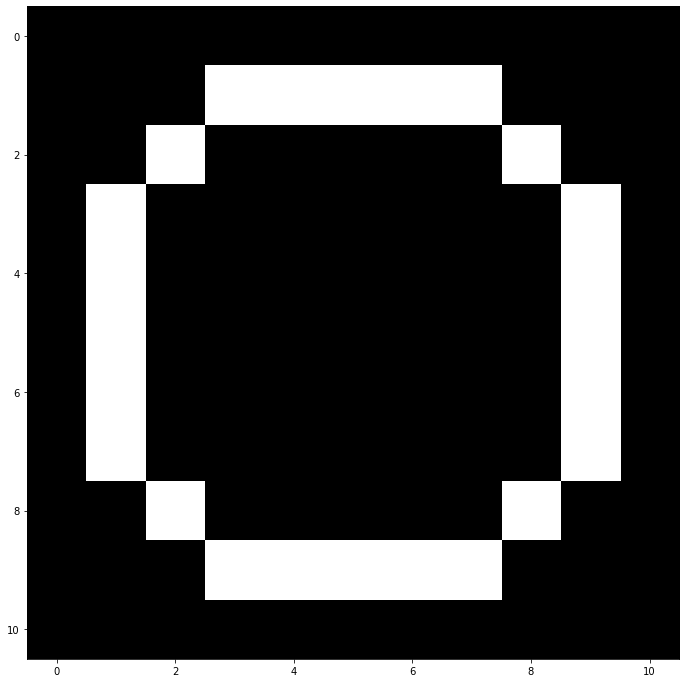

In [24]:
bou = seg.find_boundaries(circ, mode="inner")
plt.imshow(bou, cmap=plt.cm.bone)

In [25]:
def make_mask_from_border(border, shape):
    newmask = np.zeros(shape=shape, dtype=bool)
    for v in border:
        newmask[v[1],v[0]] = True
    return newmask

circles_start= (2, 2)
possible trouble


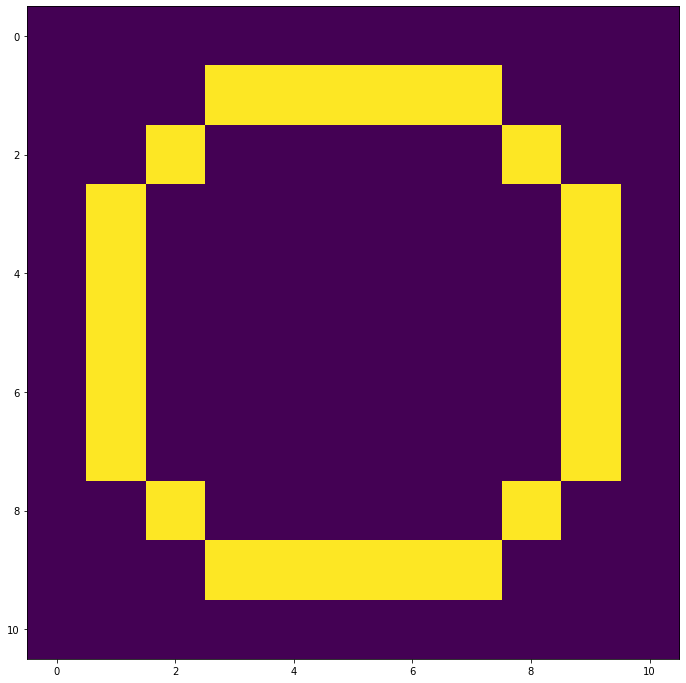

In [26]:
circles_start = get_left_start_points(bou)
print('circles_start=',circles_start)
circles_border = moree(bou, circles_start, (circles_start[0]-1,circles_start[1]-1))
plt.imshow(make_mask_from_border(circles_border, bou.shape))

In [27]:
def isRight(start, end, point):
    # point p0(x0, y0) to p1(x1, y1) tooo p2(x2, y2) 
    return ((end[0] - start[0])*(point[1] - start[1]) - (point[0] - start[0])*(end[1] - start[1])) <= 0 ;
    

# def non_adaptive(border):
#     STEP_LENGTH = 5
#     bord = border.copy() 
#     res = [bord.pop(0)]
#     print(id(border), id(bord))
#     line_start = None
#     line_end = None
#     while len(bord):
#         print('res=',res)
#         print('bord=', bord)
#         line_start = res[-1]
#         line_end = bord.pop(0)
#         for i in range(STEP_LENGTH - 2):
#             newpoint = bord.pop(0)
#             if newpoint == border[-1]:
#                 print('HEYYO UTSO')
#                 break
#             print('isRight(line_start, line_end, newpoint):',line_start,line_end, newpoint, isRight(line_start, line_end, newpoint))
#             if isRight(line_start, line_end, newpoint):
#                 print('line:',line_start,line_end,'"s right point:', newpoint)
#                 line_end = newpoint
#         res.append(line_end)
#         print(line_end, 'appended')
#     return res


def non_adaptive(border, STEP_LENGTH=5):
    res = [border[0]]
    start_ind = 0
    
    while border[start_ind] !=  border[-1]:
        line_start = border[start_ind]
        line_end = border[start_ind+1]

        for i in range(start_ind+2, start_ind+STEP_LENGTH):
            #print(i, line_start, line_end, border[i])
            if border[i] == border[-1]:
                print('breaked')
                res.append(border[i])
                return res
            if isRight(line_start, line_end, border[i]):

                line_end = border[i]
                start_ind = i
        start_ind = border.index(line_end)
        res.append(line_end)
    return res
    




[(2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (8, 8), (7, 9), (6, 9), (5, 9), (4, 9), (3, 9), (2, 8), (1, 7), (1, 6), (1, 5), (1, 4), (1, 3)]


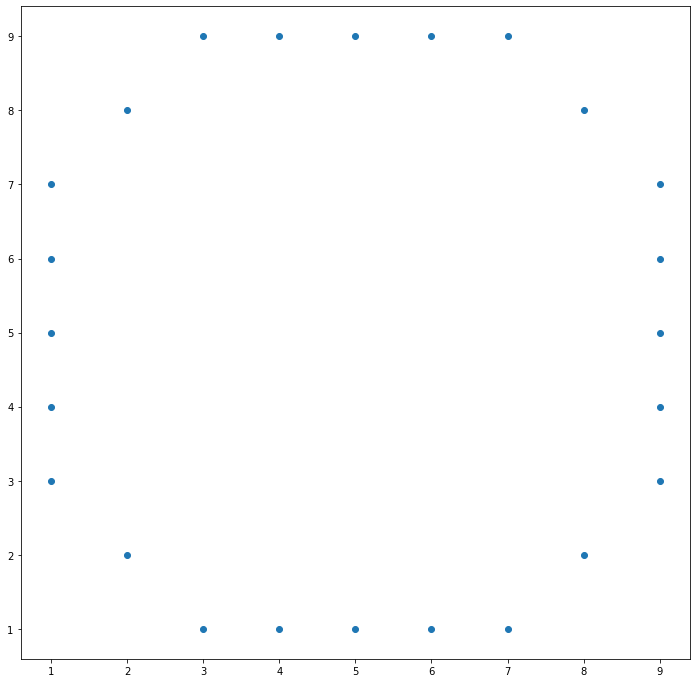

In [28]:
print(circles_border)
x, y = zip(*circles_border)
plt.scatter(x,y)

breaked
[(2, 2), (3, 1), (7, 1), (9, 3), (9, 7), (7, 9), (3, 9), (1, 7), (1, 3)]


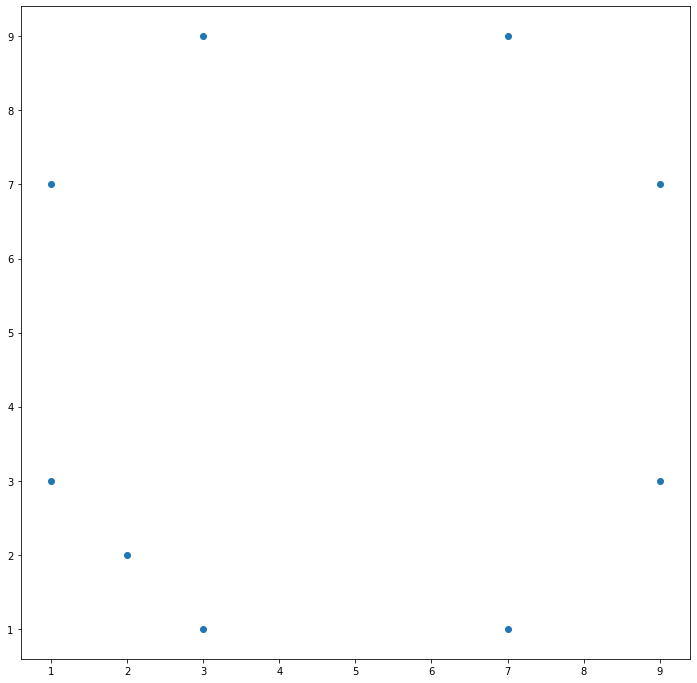

In [29]:
asd = non_adaptive(circles_border)
print(asd)
x, y = zip(*asd)
plt.scatter(x,y)

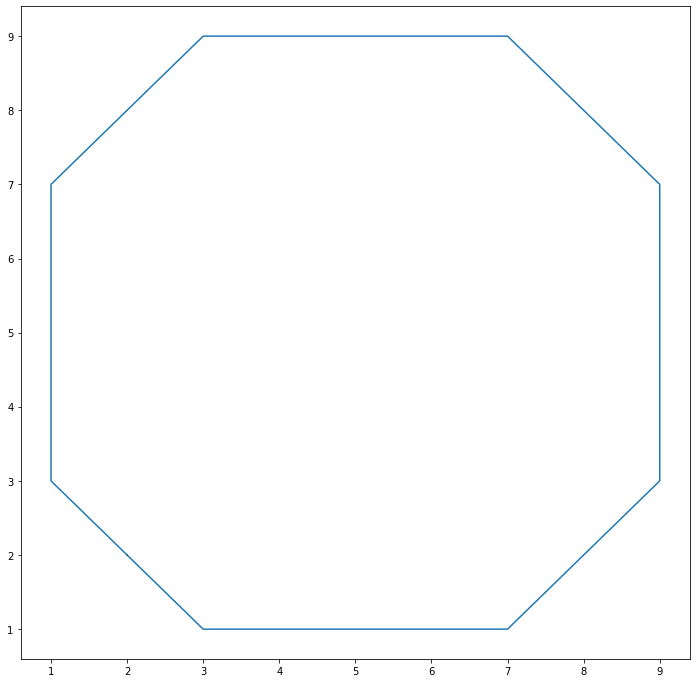

In [30]:

asd.append(asd[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*asd)
plt.plot(xs,ys) 

left: (134, 134) right: (387, 124)
possible trouble
possible trouble


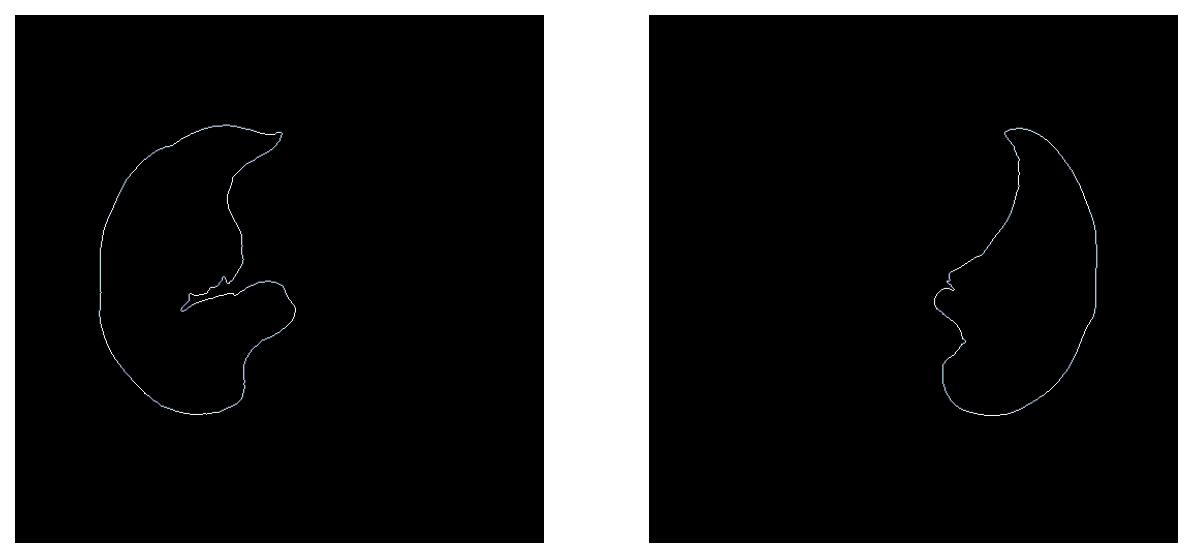

In [31]:
%matplotlib inline
lp = get_left_start_points(lung_mask)
rp = get_right_start_points(lung_mask)
print('left:', lp, 'right:', rp)

leftie_border = moree(boundaries, lp, (lp[0]-1,lp[1]-1))
rightie_border = moree(boundaries, rp, (rp[0]+1,rp[1]-1))

leftie = make_mask_from_border(leftie_border, lung_mask.shape)
rightie = make_mask_from_border(rightie_border, lung_mask.shape)

#plt.imshow(rightie)
plot_two_cols(leftie, rightie)

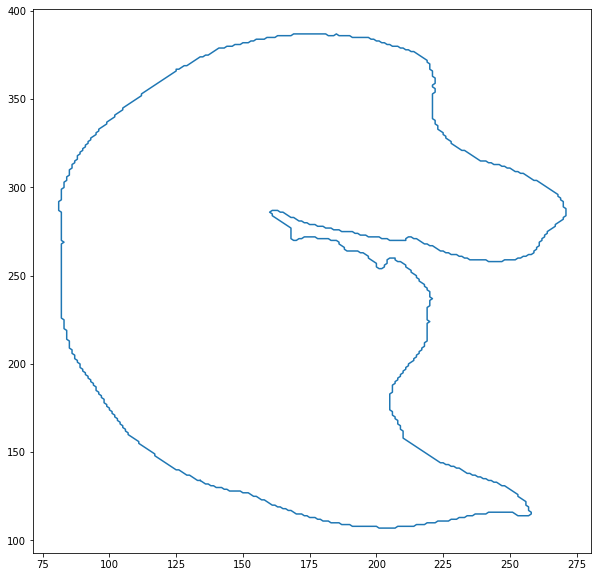

In [32]:

leftie_border_vis = leftie_border.copy()
leftie_border_vis.append(leftie_border_vis[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*leftie_border_vis)
orgleftvis = plt.plot(xs,ys)

breaked


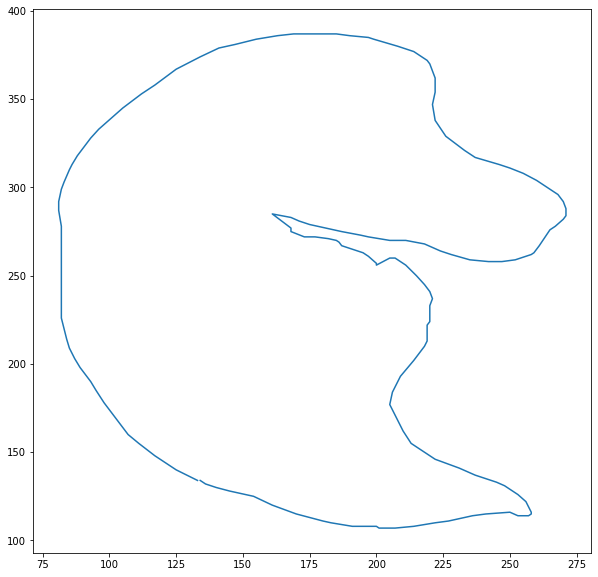

In [33]:
leftie_border_nonadapt = non_adaptive(leftie_border, 10)
#repeat the first point to create a 'closed loop'

xs, ys = zip(*leftie_border_nonadapt)
plt.plot(xs,ys)
#print(leftie_border_nonadapt)

In [34]:
myboundary = np.logical_or(leftie, rightie)

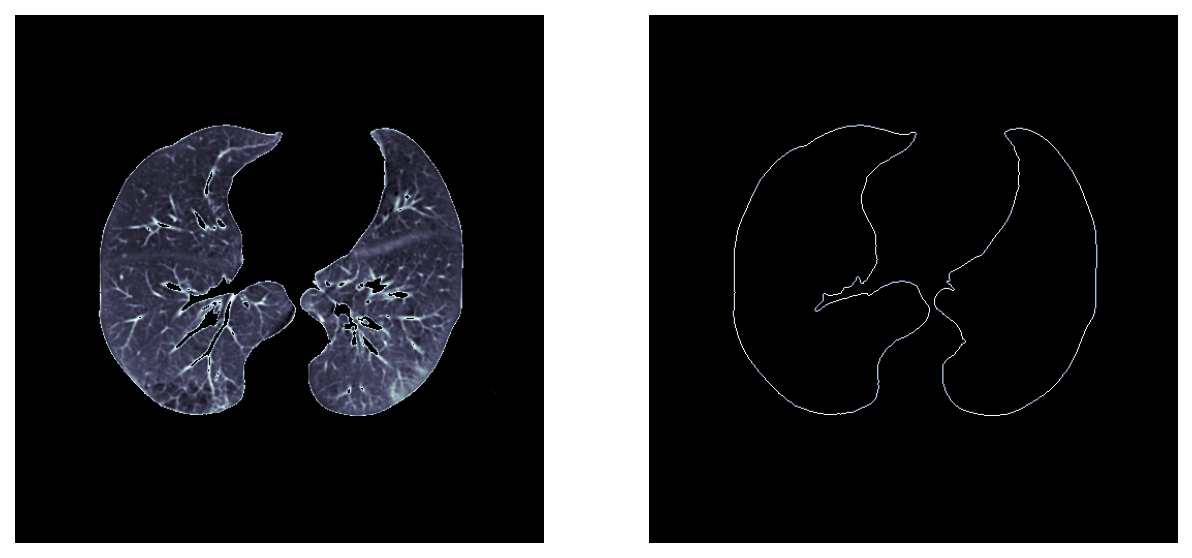

In [35]:
# a jobboldali kellene rarajzolnom a baloldalira.
plot_two_cols(filled, myboundary)

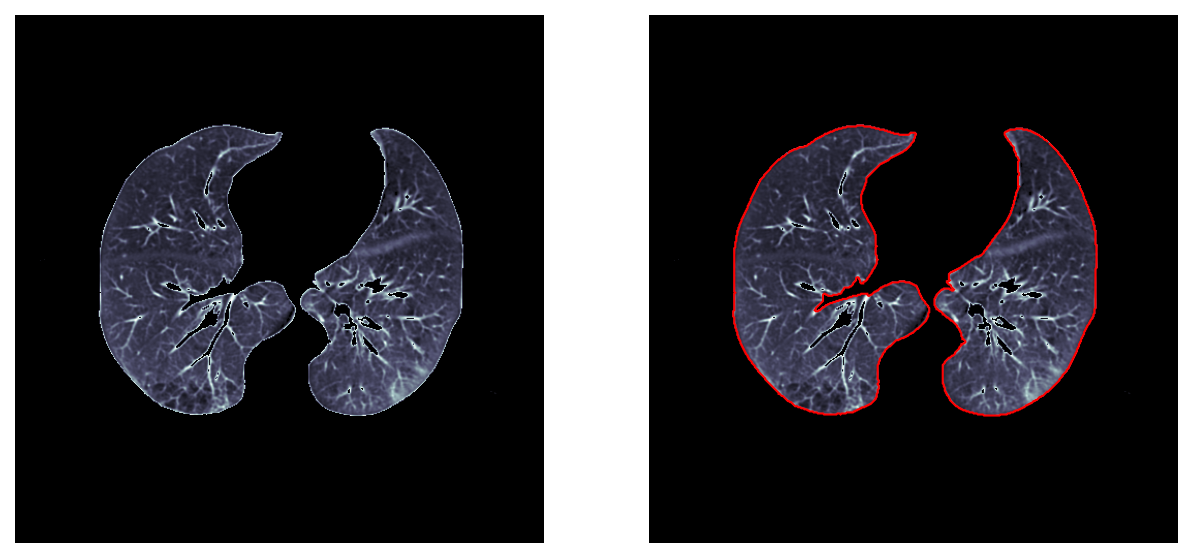

In [36]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
left_path = Path(leftie_border)
right_path = Path(rightie_border)
left_patch = PathPatch(left_path, fill=False, ec='red')
right_patch = PathPatch(right_path, fill=False, ec='red')
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=150)
[axi.set_axis_off() for axi in axs]
axs[0].imshow(filled, cmap=plt.cm.bone)
axs[1].add_patch(left_patch)
axs[1].add_patch(right_patch)
axs[1].imshow(filled, cmap=plt.cm.bone)

In [37]:
def connect_nd(ends):
    d = np.diff(ends, axis=0)[0]
    j = np.argmax(np.abs(d))
    D = d[j]
    aD = np.abs(D)
    return ends[0] + (np.outer(np.arange(aD + 1), d) + (aD>>1)) // aD

In [48]:
def make_mask_from_nonadaptive_border(border_nonadapt, shape):
    asd = [connect_nd(xy) for xy in list(zip(border_nonadapt[1:], border_nonadapt))]
    asd = make_mask_from_border(np.vstack(asd), shape)
    return asd

breaked
breaked


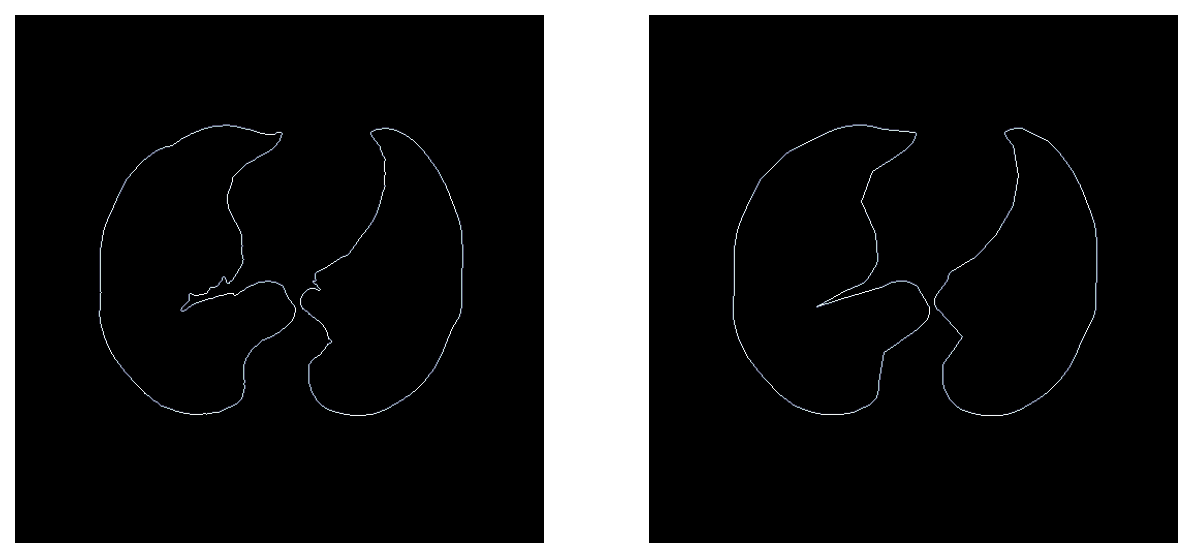

In [50]:
STEP_LENGTH = 30
leftie_border_nonadapt = non_adaptive(leftie_border, STEP_LENGTH)
rightie_border_nonadapt = non_adaptive(rightie_border, STEP_LENGTH)

leftie_nonadapt = make_mask_from_nonadaptive_border(leftie_border_nonadapt, lung_mask.shape)
rightie_nonadapt = make_mask_from_nonadaptive_border(rightie_border_nonadapt, lung_mask.shape)

nonadapt = np.logical_or(leftie_nonadapt, rightie_nonadapt)
plot_two_cols(myboundary, nonadapt)


In [ ]:
np.nonzero(boundaries)

In [ ]:
bou = seg.find_boundaries(circ, mode="inner")
plt.imshow(bou, cmap=plt.cm.bone)

In [ ]:
sp = get_start_points(bou)
print('sp=',sp)
bordam = get_border_from_startpoint(sp[0],bou)
majmask = make_mask_from_border(bordam, shape=bou.shape)
plt.imshow(majmask, cmap=plt.cm.bone)

In [ ]:
plt.imshow(boundaries[290:310, 250:270], cmap=plt.cm.bone)

In [ ]:
# boundaries
print('start_points=',start_points)
borderline = get_border_from_startpoint((19,2),boundaries[290:310, 250:270])
left = make_mask_from_border(borderline, shape=boundaries[290:310, 250:270].shape)
plt.imshow(boundaries[290:310, 250:270], cmap=plt.cm.bone)

In [ ]:
# boundaries
print('start_points=',start_points)
borderline = get_border_from_startpoint(start_points[0],boundaries)
left = make_mask_from_border(borderline, shape=boundaries.shape)
plt.imshow(boundaries, cmap=plt.cm.bone)

In [ ]:
# def get_moore_nextneighbor(point, mask):
#     directions = [(0,-1),(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1)]
#     for i, dire in enumerate(directions):
#         new = tuple(np.add(point,dire))
#         if mask[new[0]][new[1]]:
#             last = tuple(np.add(point,directions[i-1]))
#             return (new,last)
    
def get_border_from_startpoint(point, mask):
    #directions = [(0,-1),(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1)]
    directions = [(0,-1),(1,-1),(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1)]
    border = [point]
    while border.count(point) == 1:
        for dire in directions:
            new = tuple(np.add(border[-1],dire))
#             maks = make_mask_from_border(border, mask.shape)
#             plt.imshow(maks)
#             plt.show()
            print('new=',new)
            print(mask[new[0]][new[1]])
            if (new == point) and len(border)>3:
                return border
            if mask[new[0]][new[1]] and ((new not in border) and (new != point)):
                border.append(new)
    return border
                



        


pass

